In [65]:
# from google.colab import drive
# drive.mount('/content/drive')

In [66]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from os import listdir
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

In [67]:
## CONFIGURATION 
EPOCHS = 10
BUFFER_SIZE = 2000
BATCH_SIZE = 1

IMG_HEIGHT = 128
IMG_WIDTH = 128

In [68]:
# image_dir = "/content/drive/My Drive/3d printer/codes/datasets/cropped-datasets/"
# masks_dir = "/content/drive/My Drive/3d printer/codes/datasets/ground-truth/"

image_dir = "./images/"
masks_dir = "./mask_images/"

In [69]:
images_list = listdir(image_dir)
masks_list = listdir(masks_dir)

img_list = [i.split('.')[0] for i in images_list]
msk_list = [i.split('.')[0] for i in masks_list]

commons = list(set(img_list) & set(msk_list))

images_path =  [image_dir + i + ".jpg"  for i in commons]
masks_path  = [masks_dir + i + ".jpg"  for i in commons]

In [70]:
masks_path[:10], images_path[:10]

(['./mask_images/751.jpg',
  './mask_images/1303.jpg',
  './mask_images/511.jpg',
  './mask_images/60.jpg',
  './mask_images/361.jpg',
  './mask_images/560.jpg',
  './mask_images/371.jpg',
  './mask_images/571.jpg',
  './mask_images/1310.jpg',
  './mask_images/932.jpg'],
 ['./images/751.jpg',
  './images/1303.jpg',
  './images/511.jpg',
  './images/60.jpg',
  './images/361.jpg',
  './images/560.jpg',
  './images/371.jpg',
  './images/571.jpg',
  './images/1310.jpg',
  './images/932.jpg'])

In [71]:
def load_images(image_path, mask_path, img_size = (IMG_HEIGHT, IMG_WIDTH)):
  # load our images from the image and mask path
  img_data = tf.io.read_file(image_path)
  img = tf.io.decode_png(img_data,channels=3)
  img = tf.image.convert_image_dtype(img,tf.float32)

  segm_data = tf.io.read_file(mask_path)
  mask = tf.io.decode_png(segm_data)
  mask = tf.math.reduce_max(mask, axis = -1, keepdims=True)
  mask = mask / 255
  # print(mask.shape)
  img = tf.image.resize(img, img_size , method = 'nearest')
  mask = tf.image.resize(mask, img_size, method = 'nearest')
  
  return img, mask

In [72]:
dataset = tf.data.Dataset.from_tensor_slices((images_path, masks_path))
dataset = dataset.map(load_images ,num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).shuffle(BUFFER_SIZE).cache()

In [73]:
# divide our dataset into training and test set
val_dataset = (dataset
               .take(200)
               .prefetch(buffer_size=tf.data.AUTOTUNE) )
train_dataset = (dataset
                .skip(200)
                .map(lambda image, label: (tf.image.random_flip_up_down(image), tf.image.random_flip_up_down(label)))
                .map(lambda image, label: (tf.image.random_flip_left_right(image), tf.image.random_flip_left_right(label)))
                .map(lambda image, label: (tf.image.random_contrast(image, lower=0.0, upper=1.0), label))               
                .prefetch(buffer_size=tf.data.AUTOTUNE)
                .repeat(5)) 
train_dataset

<RepeatDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>

In [74]:
train_dataset.cardinality().numpy()

3900

2024-03-16 12:10:54.597987: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


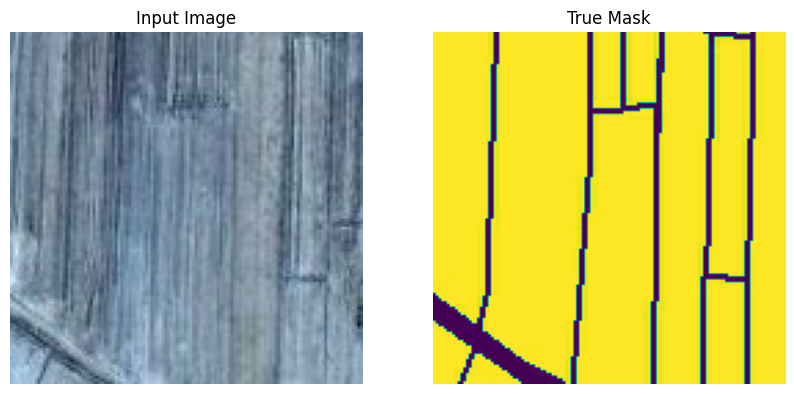

In [75]:
# plot images
def display(display_list):
  plt.figure(figsize=(10,10))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
    
N = 1
for image,mask in dataset.take(N):
  sample_image, sample_mask = image[0],mask[0]
  display([sample_image,sample_mask])
  

In [76]:
sample_mask.shape

TensorShape([128, 128, 1])

## segnet Model


In [77]:
def segnet():
    l1 = 16
    # Encoding layer
    img_input = Input(shape= (IMG_HEIGHT, IMG_WIDTH, 3))
    x = Conv2D(l1*4, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = Activation('relu')(x)
    x = Conv2D(l1*4, (3, 3), padding='same', name='conv2')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(l1*8, (3, 3), padding='same', name='conv3')(x)
    x = Activation('relu')(x)
    x = Conv2D(l1*8, (3, 3), padding='same', name='conv4')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = MaxPooling2D()(x)

    x = Conv2D(l1*16, (3, 3), padding='same', name='conv5')(x)
    x = Activation('relu')(x)
    x = Conv2D(l1*16, (3, 3), padding='same', name='conv6')(x)
    x = Activation('relu')(x)
    x = Conv2D(l1*16, (3, 3), padding='same', name='conv7')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = MaxPooling2D()(x)

    x = Conv2D(l1*32, (3, 3), padding='same', name='conv8')(x)
    x = Activation('relu')(x)
    x = Conv2D(l1*32, (3, 3), padding='same', name='conv9')(x)
    x = Activation('relu')(x)
    x = Conv2D(l1*32, (3, 3), padding='same', name='conv10')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(l1*32, (3, 3), padding='same', name='conv11')(x)
    x = Activation('relu')(x)
    x = Conv2D(l1*32, (3, 3), padding='same', name='conv12')(x)
    x = Activation('relu')(x)
    x = Conv2D(l1*32, (3, 3), padding='same', name='conv13')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = MaxPooling2D()(x)

    x = Dense(l1*64, activation = 'relu', name='fc1')(x)
    x = Dense(l1*64, activation = 'relu', name='fc2')(x)

    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(l1*32, (3, 3), padding='same', name='deconv1')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(l1*32, (3, 3), padding='same', name='deconv2')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(l1*32, (3, 3), padding='same', name='deconv3')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(l1*32, (3, 3), padding='same', name='deconv4')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(l1*32, (3, 3), padding='same', name='deconv5')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(l1*16, (3, 3), padding='same', name='deconv6')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(l1*16, (3, 3), padding='same', name='deconv7')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(l1*16, (3, 3), padding='same', name='deconv8')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(l1*8, (3, 3), padding='same', name='deconv9')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(l1*8, (3, 3), padding='same', name='deconv10')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(l1*4, (3, 3), padding='same', name='deconv11')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(l1*4, (3, 3), padding='same', name='deconv12')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = Activation('softmax')(x)
    pred = Reshape((IMG_HEIGHT, IMG_WIDTH, 1))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    return model

In [78]:
model = segnet()

In [79]:
# from keras.optimizers import Adam

model.compile(
     optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=['accuracy'],
  )

In [80]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 64)      1792      
                                                                 
 activation_78 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 conv2 (Conv2D)              (None, 128, 128, 64)      36928     
                                                                 
 activation_79 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 dropout_30 (Dropout)        (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 64, 64)       0   

In [81]:
callbacks = [
    # ReduceLROnPlateau(patience=3, verbose=1),
    # EarlyStopping(patience=12, verbose=1),
    ModelCheckpoint('segnet-model.h5', verbose=0, save_best_only=True,save_weights_only=True)
    ]

In [82]:
  # fiting the model
history = model.fit(
      train_dataset,
      epochs=EPOCHS,
      validation_data = val_dataset,
      validation_steps = 8,
      callbacks = callbacks, 
    )

Epoch 1/10


3900/3900 [==============================] - 160s 41ms/step - loss: 3.3841 - accuracy: 0.7117 - val_loss: 1.5506 - val_accuracy: 0.8174
Epoch 2/10
3900/3900 [==============================] - 156s 40ms/step - loss: 3.3841 - accuracy: 0.7117 - val_loss: 1.5506 - val_accuracy: 0.8174
Epoch 3/10
3900/3900 [==============================] - 156s 40ms/step - loss: 3.3841 - accuracy: 0.7117 - val_loss: 1.5506 - val_accuracy: 0.8174
Epoch 4/10
3900/3900 [==============================] - 156s 40ms/step - loss: 3.3841 - accuracy: 0.7117 - val_loss: 1.5506 - val_accuracy: 0.8174
Epoch 5/10
3900/3900 [==============================] - 156s 40ms/step - loss: 3.3841 - accuracy: 0.7117 - val_loss: 1.5506 - val_accuracy: 0.8174
Epoch 6/10
3900/3900 [==============================] - 156s 40ms/step - loss: 3.3841 - accuracy: 0.7117 - val_loss: 1.5506 - val_accuracy: 0.8174
Epoch 7/10
3900/3900 [==============================] - 156s 40ms/step - loss: 3.3841 - accuracy: 0.7117 - val_loss: 1.5506 - val

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


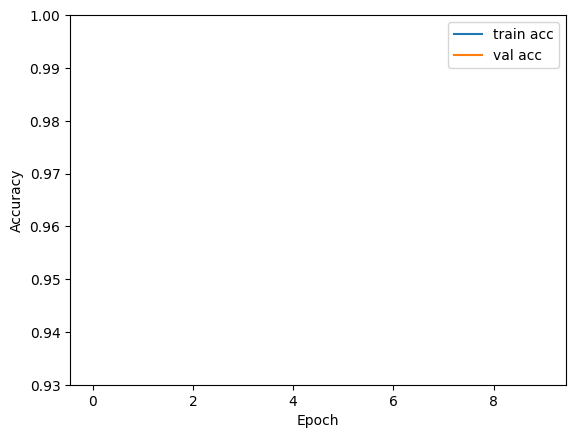

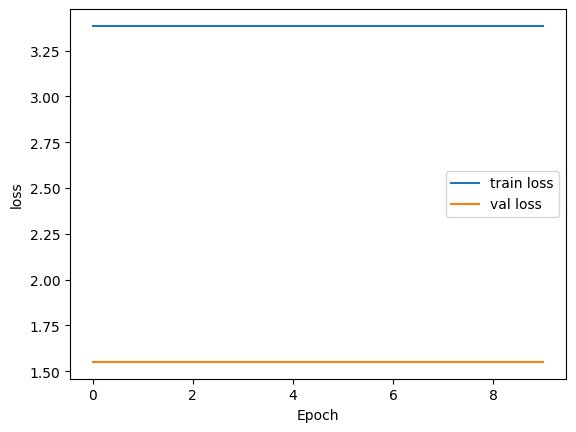

In [83]:
plt.plot(history.history["accuracy"], label='train acc')
plt.plot(history.history["val_accuracy"], label='val acc')
plt.ylim([0.93, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history["loss"], label='train loss')
plt.plot(history.history["val_loss"], label='val loss')
# plt.ylim([0.93, 1])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [84]:
def create_mask(pred_mask):
    # pred_mask = tf.argmax(pred_mask, axis=-1)
    pred = pred_mask[0]
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0

    # pred_mask = pred_mask[..., tf.newaxis]
    return pred

In [85]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image, verbose=0)
            # print(pred_mask[0][pred_mask[0]>0.5])
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

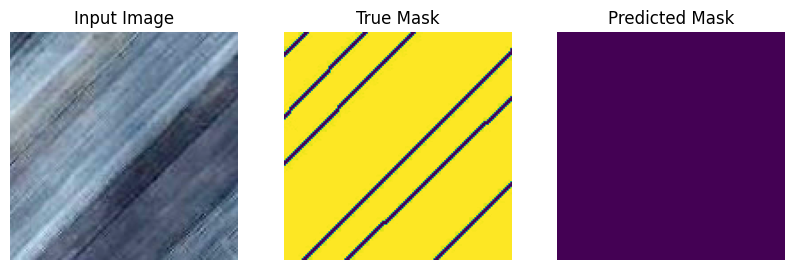

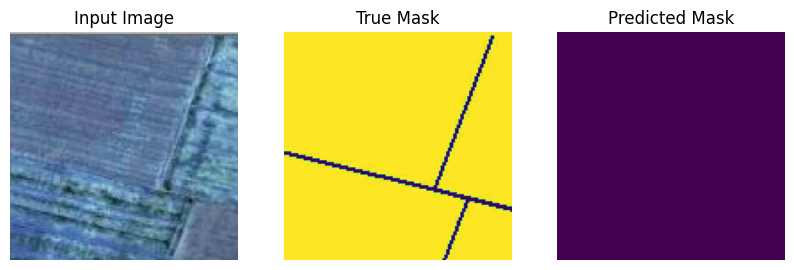

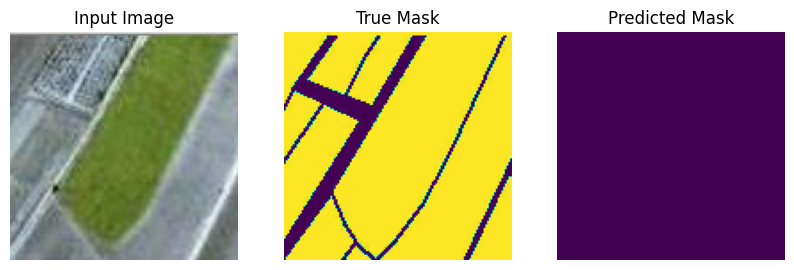

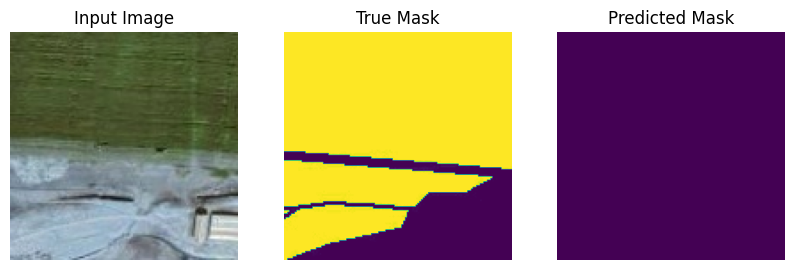

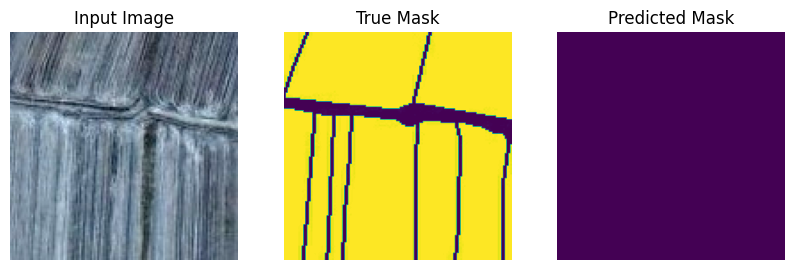

In [86]:
## displaying our result
show_predictions(val_dataset,num=5)